<a href="https://colab.research.google.com/github/iceQHdrop/bioinformatic_data_mining/blob/main/ML_for_donar_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for donar finding

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! cp -r drive/MyDrive/Colab_Notebooks/bioinformatic_data_mining/dataset ./

In [16]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## 数据读取

### 设定路径名

In [4]:
train_path = 'dataset/TrainingSet'
test_path = 'dataset/TestingSet'    
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)


### 读取训练数据

#### 定义读取函数

In [5]:
def LoadData(files, file_path):
    site_seqs = []
    normal_seqs = []

    print(f'Loading data from {file_path}...')

    for file in tqdm(files):
        with open(file_path + '/' + file, 'r') as f:
            text = f.readlines()
            site_positions = re.findall('(\d+)(?=,)', text[1])    # 提取位置
            seq = ''.join(text[2:]).replace('\n', '').lower()
        
            for position in site_positions:
                site_seqs.append(seq[int(position) - 4:int(position) + 5])
        
            for num in range(4):    # 提取非位点序列
                normal_position = np.random.randint(len(seq) - 9)    # 采样至倒数第九位
                normal_seq = seq[normal_position - 4:normal_position + 5]

                while normal_position in site_positions or \
                    set(normal_seq) != {'a', 't', 'c', 'g'} or \
                    len(normal_seq) != 9:    # 排除donar位点与'n', 'm' 等

                    normal_position = np.random.randint(len(seq) - 9)
                    normal_seq = seq[normal_position - 4:normal_position + 5]

                normal_seqs.append(normal_seq)
    
    site_df = pd.DataFrame(list(zip(site_seqs, np.ones(len(site_seqs)))),    # 位点
                            columns = ['Seq', 'Donar'])

    normal_df = pd.DataFrame(list(zip(normal_seqs, np.zeros(len(normal_seqs)))),    # 非位点
                              columns = ['Seq', 'Donar'])

    df = pd.concat([site_df, normal_df]).reset_index(drop = True)

    return df
  

#### 读取数据   

In [6]:
train_df = LoadData(train_files, train_path)
test_df = LoadData(test_files, test_path)

Loading data from dataset/TrainingSet...


100%|██████████| 462/462 [00:00<00:00, 6228.54it/s]


Loading data from dataset/TestingSet...


100%|██████████| 570/570 [00:00<00:00, 7628.32it/s]


## 特征提取

### One-hot 编码

In [7]:
X_train = train_df['Seq'].str.split('', expand = True).iloc[:, 1:10]
X_train = pd.get_dummies(X_train)
y_train = train_df['Donar']
X_train

,1_a,1_c,1_g,1_t,2_a,2_c,2_g,2_t,3_a,3_c,...,7_g,7_t,8_a,8_c,8_g,8_t,9_a,9_c,9_g,9_t
0,0,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
4225,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4226,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
4227,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [8]:
X_test = test_df['Seq'].str.split('', expand = True).iloc[:, 1:10]
X_test = pd.get_dummies(X_test)
y_test = test_df['Donar']
X_test.head()

,1_a,1_c,1_g,1_t,2_a,2_c,2_g,2_t,3_a,3_c,...,7_g,7_t,8_a,8_c,8_g,8_t,9_a,9_c,9_g,9_t
0,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


## SVM

In [9]:
clf = SVC(probability = True)

In [10]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
auc_roc = auc(fpr, tpr)
auc_roc

0.9982420276279925

## ANN

### 确定设备

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The model will be running on {device}.')

The model will be running on cpu.


### 定义模型

In [123]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 5, kernel_size = 3, padding = 1),
                                    nn.ReLU(True),
                                    nn.Conv2d(5, 10, kernel_size = 3, padding = 1),
                                    nn.ReLU(True),
                                    nn.Flatten(),
                                    nn.Linear(4*9*10, 500),
                                    nn.ReLU(True),
                                    nn.Linear(500, 1000), 
                                    nn.ReLU(True),
                                    nn.Linear(1000, 1000),
                                    nn.ReLU(True),
                                    nn.Linear(1000, 2),
                                    nn.Softmax())
        
    def forward(self, X):
        X = X.view(-1, 1, 9, 4)
        return self.layers(X)

### 模型结构

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


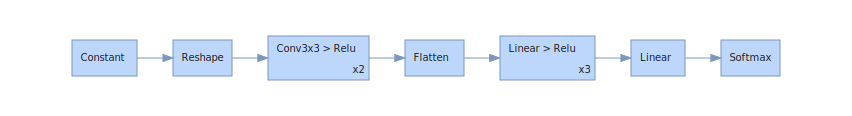

In [143]:
import hiddenlayer as h
vis_graph = h.build_graph(CNN(), torch.zeros([1 ,1, 9, 4]))   # 获取绘制图像的对象
vis_graph.theme = h.graph.THEMES["blue"].copy()
vis_graph

### 重新定义数据特征表示

#### 定义编码函数

In [124]:
def OneHot(seq):
    base_dict = {'a': 0, 't': 1, 'c': 2, 'g': 3}
    seq_list = [base_dict[base] for base in seq]
    seq_tensor = torch.tensor(seq_list)
    return F.one_hot(seq_tensor).tolist()

#### 编码

In [125]:
X_train_cnn = torch.tensor(train_df['Seq'].apply(OneHot).values.tolist(), 
                           dtype = torch.float)
X_test_cnn = torch.tensor(test_df['Seq'].apply(OneHot).values.tolist(), 
                          dtype = torch.float)
y_train_cnn = torch.tensor(train_df['Donar'])
y_test_cnn = torch.tensor(test_df['Donar'])
X_train_cnn[0]

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])

### 装入DataSet

In [128]:
whole_train_set = TensorDataset(X_train_cnn, y_train_cnn)
test_set = TensorDataset(X_test_cnn, y_test_cnn)

### 定义训练函数

In [174]:
def train(whole_train_set):
    train_set, valid_set = random_split(whole_train_set, [int(0.8*len(whole_train_set)),
                                                            len(whole_train_set) - int(0.8*len(whole_train_set))])
    train_loader = DataLoader(train_set, batch_size = int(0.2*len(train_set)), shuffle = True)
    valid_loader = DataLoader(valid_set, batch_size = int(0.5*len(valid_set)), shuffle = True)
    
    model = CNN()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    best_accuracy = 0
    
    for epoch in range(200):
        running_train_loss = 0.0  
        running_val_loss = 0.0
        correct, total = 0, 0 
        for i, data in enumerate(train_loader, 0):
            X = data[0].to(device)
            y = data[1].to(device)
            optimizer.zero_grad()
            
            outputs = model(X)  
            loss = criterion(outputs, y.long())
            loss.backward()
            optimizer.step()
            running_train_loss += loss
        
        train_loss = running_train_loss/len(train_loader)
        
        with torch.no_grad():
            model.eval()
            
            for i, data in enumerate(valid_loader, 0):
                X = data[0].to(device)
                y = data[1].to(device)
            
                outputs = model(X)
                loss = criterion(outputs, y.long())
                _, y_pred = torch.max(outputs, dim = 1)
                running_val_loss += loss
                total += outputs.size(0)
                correct += (y == y_pred).sum().item()
            
        val_loss = running_val_loss/len(valid_loader)
        
        accuracy = 100*correct/total
        
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), f'./best_model.pth')
            print('The model has been saved for the best accuracy %d %%'%(accuracy))
            best_accuracy = accuracy
        
        if epoch == 0:
            print('The model is working fine!')

        if (epoch + 1)%100 == 0:
            print('Completed training epoch', epoch + 1, 'Training Loss is: %.4f' %train_loss, 'Validation Loss is: %.4f' %val_loss, 'Accuracy is %d %%' % (accuracy))

### 训练

In [175]:
train(whole_train_set)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


The model has been saved for the best accuracy 48 %
The model is working fine!
The model has been saved for the best accuracy 92 %
The model has been saved for the best accuracy 92 %
The model has been saved for the best accuracy 93 %
The model has been saved for the best accuracy 94 %
The model has been saved for the best accuracy 94 %
The model has been saved for the best accuracy 94 %
The model has been saved for the best accuracy 95 %
The model has been saved for the best accuracy 95 %
The model has been saved for the best accuracy 96 %
The model has been saved for the best accuracy 96 %
The model has been saved for the best accuracy 96 %
The model has been saved for the best accuracy 97 %
The model has been saved for the best accuracy 97 %
The model has been saved for the best accuracy 97 %
The model has been saved for the best accuracy 97 %
The model has been saved for the best accuracy 97 %
The model has been saved for the best accuracy 97 %
Completed training epoch 100 Training

In [176]:
def test(test_set):
    model = CNN()
    model.to(device)
    model.load_state_dict(torch.load(f'./best_model.pth'))
    model.eval()
    
    X = test_set[:][0].to(device)
    y = test_set[:][1].to(device)
    
    y_pred = model(X)[:, 1]
    print(y_pred)
    fpr, tpr, _ = roc_curve(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    print("AUC:{:.4f} on test data.".format(auc(fpr, tpr)))

In [177]:
test(test_set)

tensor([0.9971, 0.9946, 0.9963,  ..., 0.0510, 0.0016, 0.0112],
       grad_fn=<SelectBackward0>)
AUC:0.9975 on test data.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
